Bank Churn prediction
===
This lecture covers predicting customer churn behavior at a bank using supervised machine learning models. It walks through the full process from exploratory data analysis to feature engineering, model training, evaluation, and deployment.

Some key points:
---
- Exploratory data analysis is done visualizing the data distributions and relationships using techniques like countplots.
- Feature engineering steps include one-hot encoding categorical variables like country and label encoding for gender.
- Several models are trained and evaluated: logistic regression, random forest, and XGBoost. Metrics like F1-score, recall, and confusion matrices are used.
- An ensemble combining the logistic regression and XGBoost models is created and shows improved performance.
- Final models are saved for deployment using pickle.
- Code is provided to run the full pipeline on Google Colab using data from Kaggle.

```
How to face the Layoff flow in Market's trend

If we are not being reused in the workplace, we can analyze customer data to understand the customer churn rate,
thereby increasing our importance and indispensability.

```

Reference
---

1. [src](https://platform.stratascratch.com/data-projects/customer-churn-prediction)
2. [src](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset), from kaggle
3. [Home work](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb), [data](https://www.kaggle.com/datasets/sebastienverpile/consumercomplaintsdata)
4. [Microsoft lecture](https://github.com/microsoft/fabric-samples/blob/main/docs-samples/data-science/ai-samples/python/AIsample%20-%20Bank%20Customer%20Churn.ipynb), [Lecture](https://github.com/microsoft/fabric-samples/blob/main/docs-samples/data-science/ai-samples/python/AIsample%20-%20Bank%20Customer%20Churn.ipynb)

   
[code](https://www.analyticsvidhya.com/blog/2022/09/bank-customer-churn-prediction-using-machine-learning/)

Steps
---
1. Load data,
    - download data from Kaggle and saved in Google drive;
    - load directly from Google drive;
2. EDA, Exploratory Data analysis
   - fill NaN if any
   - Feature distributed
3. Feature Engineering
   - drop un-required features
   - convert by standardization, normalization
   - create new features
   - convert categorical data to numerical data,
   - binning numerical data binary
   - encode non-numerical data
   - data imbanlance
4. modeling
   - split data into train-test sets
   - cv folding
   - feature importance
   - hyperparameters
   - cross-validation
   - implement

5 ...    

Run in Google Drive, colab
---

1. Login google drive, add `colab` plugin
2. create 2024 foloder, enter it and create data, named data; download data from Kaggle to it.
3. create colab, open left menu and upload kaggle data intp `data`
4. run

In [8]:
# feature encoder
!pip install -q category_encoders

In [9]:
#!pip install -q -U imblearn
!pip install -q -U imbalanced-learn

In [10]:
!pip install -U -q xgboost lightgbm catboost

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

import gc
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy import stats
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import category_encoders as ce

from collections import Counter
from imblearn.over_sampling import SMOTE


import pickle
import seaborn as sns

import itertools

import warnings
warnings.filterwarnings("ignore")



```
# This is formatted as code
```

1 Load Data
---

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
data= '/content/gdrive/MyDrive/2023/2023-2-Python-AI/data/archive.zip'
df=pd.read_csv(data)

In [14]:
df.head(2)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


2 Exploratory Data Analaysis, EDA
---

In [15]:
# 10 numerical feathers, 2 object ones; and target is churn
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [16]:
# good, no null cell
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [17]:
# rate of churn; too low to take care
# only 20 % in churm

df[['churn']].mean()

churn    0.2037
dtype: float64

In [18]:
# churn indepement of one's gender

df.groupby("gender").agg({"churn": ["mean","count"]})

churn      
            mean count
gender                
Female  0.250715  4543
Male    0.164559  5457

In [19]:
# churn rate of Germany is igher than others

df.groupby("country").agg({"churn": ["mean","count"]})

churn      
             mean count
country                
France   0.161548  5014
Germany  0.324432  2509
Spain    0.166734  2477

In [20]:
#  churn rate indepent of whether owns creredict card

df.groupby("credit_card").agg({"churn": ["mean","count"]})

churn      
                 mean count
credit_card                
0            0.208149  2945
1            0.201843  7055

In [21]:
# churn rate is lower if one registered from activity

df.groupby("active_member").agg({"churn": ["mean","count"]})


churn      
                   mean count
active_member                
0              0.268509  4849
1              0.142691  5151

In [22]:
# the more one purchased, the more one is in churn state

df.groupby("products_number").agg({"churn": ["mean","count"]})

churn      
                     mean count
products_number                
1                0.277144  5084
2                0.075817  4590
3                0.827068   266
4                1.000000    60

In [23]:
# no info?
df.groupby("tenure").agg({"churn": ["mean","count"]})

churn      
            mean count
tenure                
0       0.230024   413
1       0.224155  1035
2       0.191794  1048
3       0.211100  1009
4       0.205258   989
5       0.206522  1012
6       0.202689   967
7       0.172179  1028
8       0.192195  1025
9       0.216463   984
10      0.206122   490

Kinds of Features
---

In [24]:
target= 'churn'
categorical_variables = [col for col in df if col in "O"
                         or df[col].nunique() <=10
                         and col not in target]
print("Categorical Features: ",categorical_variables)

Categorical Features:  ['country', 'gender', 'products_number', 'credit_card', 'active_member']


In [25]:
numeric_variables = [col for col in df.columns if df[col].dtype != "object"
                        and df[col].nunique() >5]
print("Numerical Features: ",numeric_variables)

Numerical Features:  ['customer_id', 'credit_score', 'age', 'tenure', 'balance', 'estimated_salary']


In [26]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

Python Syntax
---
1. Suppose that
```
X=[X0,X1,X2,...]
```
`enumerate(X)` display out:
```
0, X0
1, X1
...
```

2. create a sequence of pictues, `(m Rows X n Columns)` pictures:
```python
fig, axes = plt.subplots(nrows = m, ncols= n)
sns.histplot(df[col], ax=axes[i][j]
```


In [27]:
# observe the numeric fertures what they are distributed, whether are instributed in Normal (Gaussian)
# visualize kde density plot and check whether in Gaussian
def kde_QQ_vis(df, cols):
    sns.set_style('whitegrid')
    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(10, 3 * len(cols)))
    for i, col in enumerate(cols):
        # Histogram for the column
        sns.histplot(df[col], kde=True, ax=axes[i][0], color='red', edgecolor='black')
        axes[i][0].set_title(f'Histogram of {col}', fontsize=12)
        axes[i][0].set_xlabel('')
        axes[i][0].set_ylabel('Density')

        # Q-Q plot for the column
        stats.probplot(df[col], dist="norm", plot=axes[i][1])
        axes[i][1].set_title(f'Q-Q Plot of {col}', fontsize=12)
        axes[i][1].set_xlabel('Theoretical Quantiles')
        axes[i][1].set_ylabel('Ordered Values')
        axes[i][1].get_lines()[0].set_color('blue')
        axes[i][1].get_lines()[1].set_color('red')
    # Adjust the layout
    plt.tight_layout()

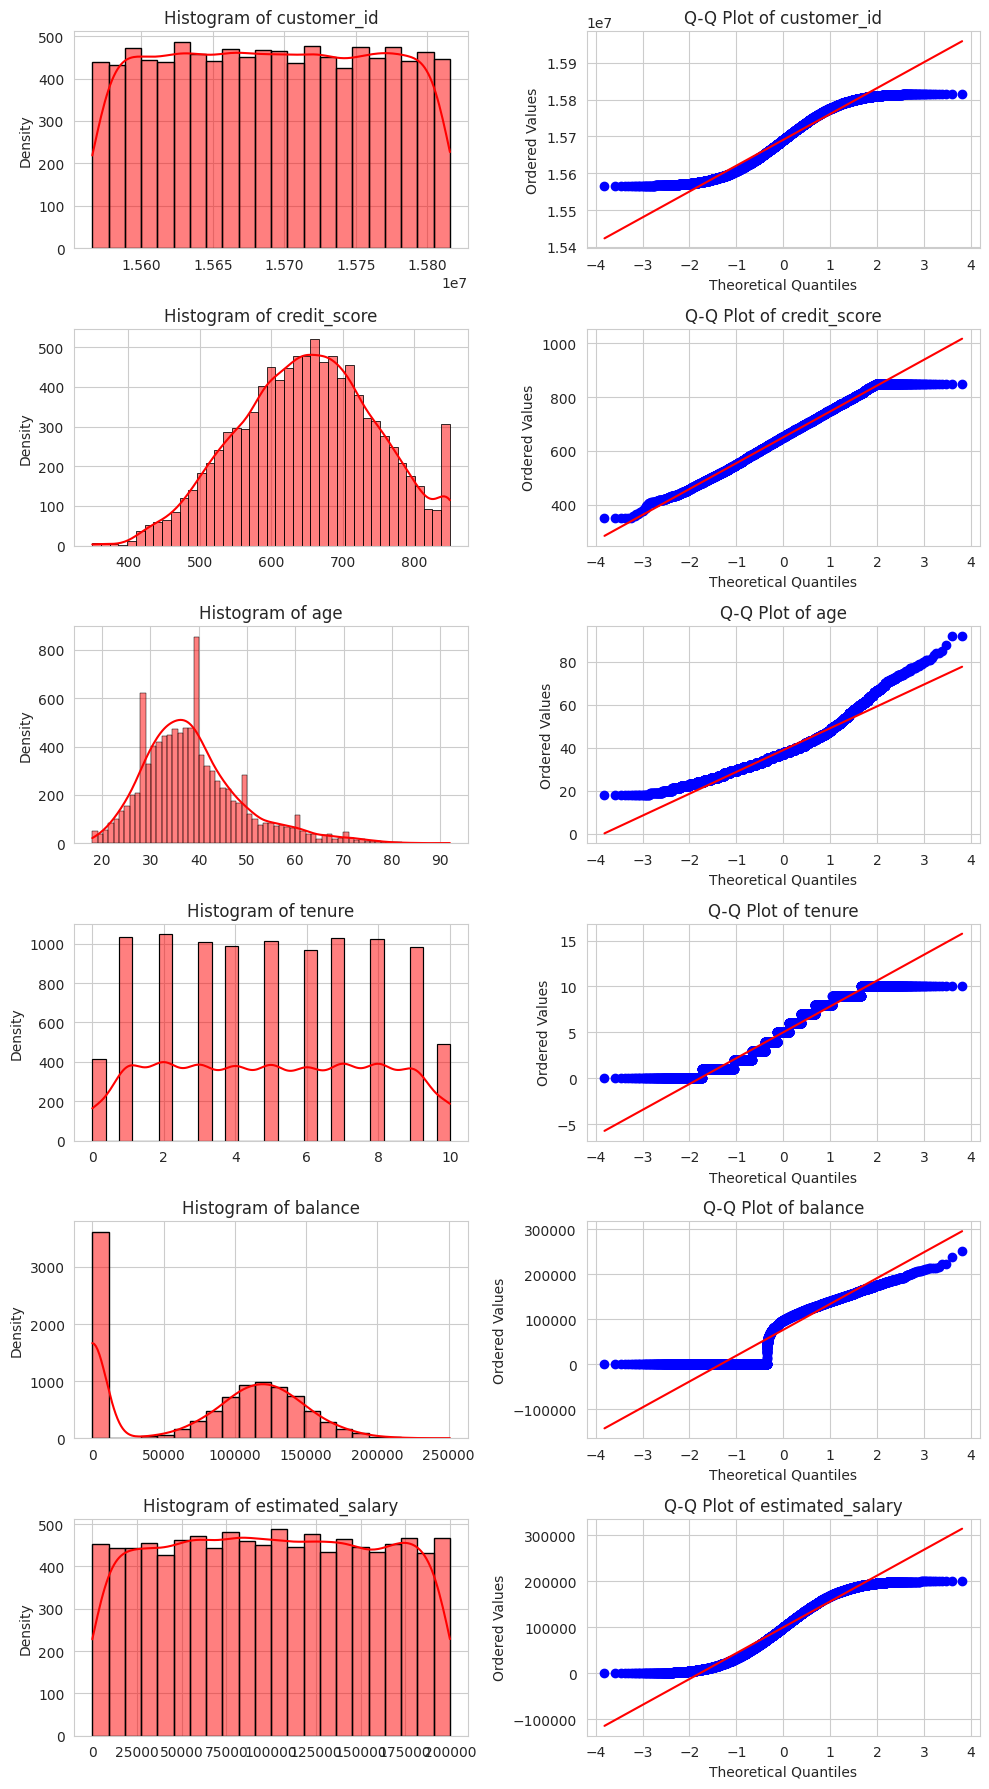

In [28]:
# check 'credit_score', 'balance', 'estimated_salary'
kde_QQ_vis(df, numeric_variables)

Conclusion
---
The features, <b>`tenue`</b> and <b>`estimated_salary`</B>, are not distributed absolutely in Gaussian obviously!

Data normalized
---
Nonamized data do help to modeling; different type
 different conversion:
 1. sklearn.preprocessing.StandardScaler: Data in normal.
 $$\bar X_i=\frac{X_i-EX}{\sigma (X)}\sim N(0,1)$$
 2. sklearn.preprocessing.MinMaxScaler: Data in abnomal
 $$ \bar X_i=\frac{X_i-X_\min}{X_\max-X_\min}\sim U(0,1)$$

In [29]:
def StandardScaler(df,cols):
    for col in cols:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df
def NormalizationScaler(df,cols):
    for col in cols:
        df[col] = (df[col] - df[col].min()) / (df[col] .max()- df[col].min())
    return df

In [30]:
gc.collect()

296

However numeric_variables[0]= `customer_id` redudent, each one owning unique one, give up.

Data Washing, (Feature Engineering)
---
There are some packages that automatical do `Feature Engineering` work, suchas
- [Featuretools](https://github.com/alteryx/featuretools),
- [sklearn](https://scikit-learn.org/stable/)
```python
from sklearn.feature_selection import f_regression
scores, _ = f_regression(df.iloc[:,0:2], df.iloc[:,-1])
print(scores)
```
- [Feature-engine](https://feature-engine.trainindata.com/en/latest/)

Here, we manually do these works:

a). delete redundant features,`customer_id`<br>
b).

In [31]:
# drop un-required features
def clean_data(df):
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    # Drop columns:  'customer_id',
    df.drop(columns=['customer_id'], inplace=True)
    return df

df_clean = clean_data(df)

In [32]:
df_clean.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [33]:
df_clean=df.copy()
df_clean.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [34]:
from sklearn.feature_selection import f_regression


In [35]:
# sklean example
# H0: the regression coefficient is equal to zero.
# i.e. non-implantant freture to be used to predictctarget

scores, p_vals = f_regression(df.iloc[:,4:9], df.iloc[:,-1])
# Print the feature names and scores
for i, score in enumerate(scores):
    print(f"Feature {i+4}: {df.columns[i+4]} - Score: {score:.3f}, with p-value: {p_vals[i]:.2f}")

Feature 4: tenure - Score: 1.960, with p-value: 0.16
Feature 5: balance - Score: 142.474, with p-value: 0.00
Feature 6: products_number - Score: 22.915, with p-value: 0.00
Feature 7: credit_card - Score: 0.509, with p-value: 0.48
Feature 8: active_member - Score: 249.801, with p-value: 0.00


In [36]:
df_clean.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [37]:
# Feature Engineering
# binning the data
df_clean["CreditsScore"] = pd.qcut(df_clean['credit_score'], 6, labels = [1, 2, 3, 4, 5, 6])
df_clean["Age"] = pd.qcut(df_clean['age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df_clean["Balance"] = pd.qcut(df_clean['balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df_clean["EstSalary"] = pd.qcut(df_clean['estimated_salary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df_clean["Tenure"] = df_clean["tenure"]/df_clean["age"]
df_clean.dtypes

credit_score           int64
country               object
gender                object
age                    int64
tenure                 int64
balance              float64
products_number        int64
credit_card            int64
active_member          int64
estimated_salary     float64
churn                  int64
CreditsScore        category
Age                 category
Balance             category
EstSalary           category
Tenure               float64
dtype: object

In [38]:
#  data

y_clean = df_clean[target]
df_clean = df_clean.drop(target,axis=1)

In [39]:
df_clean.dtypes

credit_score           int64
country               object
gender                object
age                    int64
tenure                 int64
balance              float64
products_number        int64
credit_card            int64
active_member          int64
estimated_salary     float64
CreditsScore        category
Age                 category
Balance             category
EstSalary           category
Tenure               float64
dtype: object

In [40]:
gc.collect()

50289

In [41]:
df_clean.nunique()

credit_score         460
country                3
gender                 2
age                   70
tenure                11
balance             6382
products_number        4
credit_card            2
active_member          2
estimated_salary    9999
CreditsScore           6
Age                    8
Balance                5
EstSalary             10
Tenure               414
dtype: int64

In [42]:
# Binary Feature value;
# convert the last four categorical features to numeric ones
features_=['CreditsScore','Age','Balance']
for f_ in features_:
    df_clean[f_] = df_clean[f_].astype(int)

df_clean['EstSalary'] = df_clean['EstSalary'].astype(float)

In [43]:
df_clean.dtypes

credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
CreditsScore          int64
Age                   int64
Balance               int64
EstSalary           float64
Tenure              float64
dtype: object

In [44]:
# prompt: delete pandas column

#df_clean.drop(columns=['age','tenure','balance','estimated_salary'],axis=1,inplace=True)

Nornamize data
---

In [45]:
df_clean=StandardScaler(df_clean,['age','balance','estimated_salary'])

In [46]:
df_clean= NormalizationScaler(df_clean,['tenure'])

In [47]:
df_clean.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,CreditsScore,Age,Balance,EstSalary,Tenure
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,3,6,1,6.0,0.047619
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,2,6,3,6.0,0.024390


In [48]:
df_clean.dtypes

credit_score          int64
country              object
gender               object
age                 float64
tenure              float64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
CreditsScore          int64
Age                   int64
Balance               int64
EstSalary           float64
Tenure              float64
dtype: object

Features Combination
---
Create hybrid feature for two features:
```
df['new_feature']=df['col1'].astype(str)+'_'+df['col2'].astype(str)
```
the features, `cols` and `cols`, have to be treated as 'string'.

In [49]:
# combine features,string feafures only

def feature_bind(df,col1,col2):
    df[col1+'_'+col2]=df[col1].astype(str)+df[col2].astype(str)
    return df

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [51]:
df_clean =  feature_bind(df_clean,'country','gender')
df_clean =  feature_bind(df_clean,'country','products_number')
df_clean =  feature_bind(df_clean,'country','Age')
df_clean =  feature_bind(df_clean,'gender','products_number')
df_clean =  feature_bind(df_clean,'gender','Age')
df_clean =  feature_bind(df_clean,'products_number','Age')

In [52]:
# data saved

saved='/content/gdrive/MyDrive/2023/2023-2-Python-AI/data/churn-data-05-24.csv'
df_clean.to_csv(saved,index=False)

In [53]:
# database diveded
#復活點
y = y_clean
X = df_clean


In [54]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,Age,Balance,EstSalary,Tenure,country_gender,country_products_number,country_Age,gender_products_number,gender_Age,products_number_Age
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,6,1,6.0,0.047619,FranceFemale,France1,France6,Female1,Female6,16
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,6,3,6.0,0.024390,SpainFemale,Spain1,Spain6,Female1,Female6,16


Feature Engineering
---
1. create new features:<br>
   a. 'gender'+'products_number'<br>
   b. 'customer': 'country'+'gender'<br>
   c. 'active_member'+'country'<br>
   d. 'country'+'products_number'<br>

In [55]:
gc.collect()

0

In [56]:
def llo_encoder(df,col,target=y):
    df[col+'_llo_enc']=df[col]
    loo_encoder = ce.LeaveOneOutEncoder(cols=[col+'_llo_enc'], sigma=0.05)
    loo_encoder.fit(df, target)
    X_encoded = loo_encoder.transform(df)
    return X_encoded

In [57]:
#obj_vars=df_clean.select_dtypes(include=['object']).columns
#obj_vars

In [58]:

f_convert=['country_gender','country_products_number','country_Age']
for col in f_convert:
    X_enc=llo_encoder(X,col)
    X=X_enc

In [59]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,Tenure,country_gender,country_products_number,country_Age,gender_products_number,gender_Age,products_number_Age,country_gender_llo_enc,country_products_number_llo_enc,country_Age_llo_enc
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,0.047619,FranceFemale,France1,France6,Female1,Female6,16,0.203450,0.224344,0.206838
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,0.024390,SpainFemale,Spain1,Spain6,Female1,Female6,16,0.212121,0.218673,0.212903


In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   credit_score                     10000 non-null  int64  
 1   country                          10000 non-null  object 
 2   gender                           10000 non-null  object 
 3   age                              10000 non-null  float64
 4   tenure                           10000 non-null  float64
 5   balance                          10000 non-null  float64
 6   products_number                  10000 non-null  int64  
 7   credit_card                      10000 non-null  int64  
 8   active_member                    10000 non-null  int64  
 9   estimated_salary                 10000 non-null  float64
 10  CreditsScore                     10000 non-null  int64  
 11  Age                              10000 non-null  int64  
 12  Balance            

In [61]:
def target_encoder(df,col,target=y):
    df[col+'_target_enc']=df[col]
    target_encoder = ce.TargetEncoder(cols=[col+'_target_enc'])
    target_encoder.fit(df, target)
    X_encoded = target_encoder.transform(df)
    return X_encoded

In [62]:

f_convert=['country_gender','country_products_number','country_Age']
for col in f_convert:
    X_enc=target_encoder(X,col)
    X=X_enc

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        10000 non-null  int64  
 1   country                             10000 non-null  object 
 2   gender                              10000 non-null  object 
 3   age                                 10000 non-null  float64
 4   tenure                              10000 non-null  float64
 5   balance                             10000 non-null  float64
 6   products_number                     10000 non-null  int64  
 7   credit_card                         10000 non-null  int64  
 8   active_member                       10000 non-null  int64  
 9   estimated_salary                    10000 non-null  float64
 10  CreditsScore                        10000 non-null  int64  
 11  Age                                 10000 

In [64]:
def glmm_encoder(df,col,target=y):
    df[col+'_glmm_enc']=df[col]
    glmm_encoder = ce.GLMMEncoder(cols=col, binomial_target=True)
    glmm_encoder.fit(df, target)
    X_encoded = glmm_encoder.transform(df)
    return X_encoded

In [65]:
#關鍵嘉興號
f_convert=['country_gender','country_products_number','country_Age']
for col in f_convert:
    X_enc=glmm_encoder(X,col)
    X=X_enc

In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        10000 non-null  int64  
 1   country                             10000 non-null  object 
 2   gender                              10000 non-null  object 
 3   age                                 10000 non-null  float64
 4   tenure                              10000 non-null  float64
 5   balance                             10000 non-null  float64
 6   products_number                     10000 non-null  int64  
 7   credit_card                         10000 non-null  int64  
 8   active_member                       10000 non-null  int64  
 9   estimated_salary                    10000 non-null  float64
 10  CreditsScore                        10000 non-null  int64  
 11  Age                                 10000 

In [67]:
# binary

X['gender']=X['gender'].apply(lambda x:1 if x=='Female' else 0)


In [68]:
X.drop(columns=['country'],axis=1,inplace=True)

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        10000 non-null  int64  
 1   gender                              10000 non-null  int64  
 2   age                                 10000 non-null  float64
 3   tenure                              10000 non-null  float64
 4   balance                             10000 non-null  float64
 5   products_number                     10000 non-null  int64  
 6   credit_card                         10000 non-null  int64  
 7   active_member                       10000 non-null  int64  
 8   estimated_salary                    10000 non-null  float64
 9   CreditsScore                        10000 non-null  int64  
 10  Age                                 10000 non-null  int64  
 11  Balance                             10000 

In [70]:
X.head(2)

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,CreditsScore,...,products_number_Age,country_gender_llo_enc,country_products_number_llo_enc,country_Age_llo_enc,country_gender_target_enc,country_products_number_target_enc,country_Age_target_enc,country_gender_glmm_enc,country_products_number_glmm_enc,country_Age_glmm_enc
0,619,1,0.293503,0.2,-1.225786,1,1,1,0.021885,3,...,16,0.203450,0.224344,0.206838,0.203450,0.224344,0.206838,FranceFemale,France1,France6
1,608,1,0.198154,0.1,0.117344,1,0,1,0.216523,2,...,16,0.212121,0.218673,0.212903,0.212121,0.218673,0.212903,SpainFemale,Spain1,Spain6


Data Imbalance
---
SMOTE + ENN

`A.` SMOTE selected each sample from the minority samples successively as the root sample for the synthesis of the new sample. <BR>
`B.` The following result was obtained by employing ENN to eliminate noise samples when the process of SMOTE is caused.

In [71]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        10000 non-null  int64  
 1   gender                              10000 non-null  int64  
 2   age                                 10000 non-null  float64
 3   tenure                              10000 non-null  float64
 4   balance                             10000 non-null  float64
 5   products_number                     10000 non-null  int64  
 6   credit_card                         10000 non-null  int64  
 7   active_member                       10000 non-null  int64  
 8   estimated_salary                    10000 non-null  float64
 9   CreditsScore                        10000 non-null  int64  
 10  Age                                 10000 non-null  int64  
 11  Balance                             10000 

In [72]:
#下面兩個擇一執行[刪除資料或編碼資料把英文前的#刪除後才可用]

In [73]:
#刪除資料
#X.drop(columns=['country_gender_glmm_enc','country_products_number_glmm_enc','country_Age_glmm_enc','gender_products_number','gender_Age','products_number_Age'],axis=1,inplace=True)

In [74]:
#編碼資料
f_convert=['country_gender_glmm_enc','country_products_number_glmm_enc','country_Age_glmm_enc','gender_products_number','gender_Age','products_number_Age']
for col in f_convert:
    X_enc=glmm_encoder(X,col)
    X=X_enc


In [80]:
#如果選擇編碼資料,執行這個把編碼產生的垃圾丟掉
X=X.iloc[:,0:-6]

In [76]:
# imbalance set
from imblearn.combine import SMOTEENN


def imbance_set(X,y):
    # Create the SMOTEENN object
    sme = SMOTEENN(random_state=42)

    # Fit and resample the data
    X_resampled, y_resampled = sme.fit_resample(X, y)

    # Counting churn values
    churn_counts = y_resampled.value_counts()
    print(churn_counts)
    return X_resampled, y_resampled

In [77]:
X.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,CreditsScore,...,country_Age_target_enc,country_gender_glmm_enc,country_products_number_glmm_enc,country_Age_glmm_enc,country_gender_glmm_enc_glmm_enc,country_products_number_glmm_enc_glmm_enc,country_Age_glmm_enc_glmm_enc,gender_products_number_glmm_enc,gender_Age_glmm_enc,products_number_Age_glmm_enc
0,619,1,0.293503,0.2,-1.225786,1,1,1,0.021885,3,...,0.206838,-0.053594,-1.749919,0.142562,FranceFemale,France1,France6,Female1,Female6,16
1,608,1,0.198154,0.1,0.117344,1,0,1,0.216523,2,...,0.212903,-0.002138,-1.782806,0.174720,SpainFemale,Spain1,Spain6,Female1,Female6,16
2,502,1,0.293503,0.8,1.332987,3,1,0,0.240675,1,...,0.206838,-0.053594,0.818596,0.142562,FranceFemale,France3,France6,Female3,Female6,36
3,699,1,0.007456,0.1,-1.225786,2,0,0,-0.108912,5,...,0.137427,-0.053594,-3.314411,-0.345496,FranceFemale,France2,France5,Female2,Female5,25
4,850,1,0.388852,0.2,0.785689,1,1,1,-0.365258,6,...,0.212903,-0.002138,-1.782806,0.174720,SpainFemale,Spain1,Spain6,Female1,Female6,16


In [81]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        10000 non-null  int64  
 1   gender                              10000 non-null  int64  
 2   age                                 10000 non-null  float64
 3   tenure                              10000 non-null  float64
 4   balance                             10000 non-null  float64
 5   products_number                     10000 non-null  int64  
 6   credit_card                         10000 non-null  int64  
 7   active_member                       10000 non-null  int64  
 8   estimated_salary                    10000 non-null  float64
 9   CreditsScore                        10000 non-null  int64  
 10  Age                                 10000 non-null  int64  
 11  Balance                             10000 

In [82]:
X,y=imbance_set(X,y)

churn
1    6988
0    4863
Name: count, dtype: int64


In [83]:
len(X)

11851

In [84]:
X.columns

Index(['credit_score', 'gender', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'CreditsScore',
       'Age', 'Balance', 'EstSalary', 'Tenure', 'country_gender',
       'country_products_number', 'country_Age', 'gender_products_number',
       'gender_Age', 'products_number_Age', 'country_gender_llo_enc',
       'country_products_number_llo_enc', 'country_Age_llo_enc',
       'country_gender_target_enc', 'country_products_number_target_enc',
       'country_Age_target_enc', 'country_gender_glmm_enc',
       'country_products_number_glmm_enc', 'country_Age_glmm_enc'],
      dtype='object')

In [85]:
features=list(X.columns)
target = 'churn'

Model
---
database -> train set and test set

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [87]:
from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [88]:
y_pred = XGB_model.predict(X_test)

In [89]:
y_pred

array([1, 0, 0, ..., 1, 1, 1])

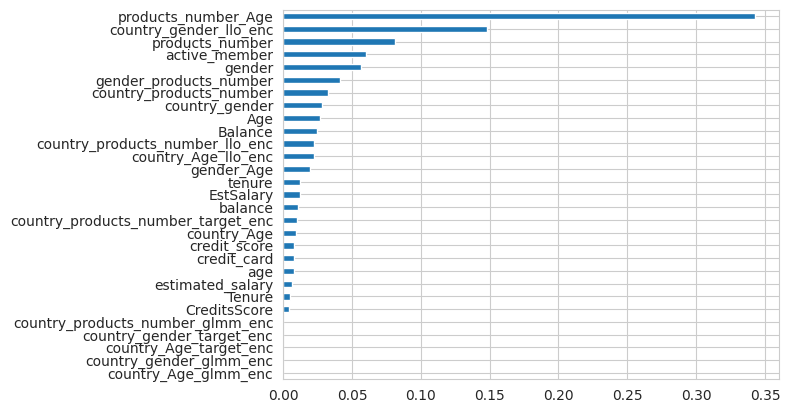

In [90]:
feat_importances = pd.Series(XGB_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

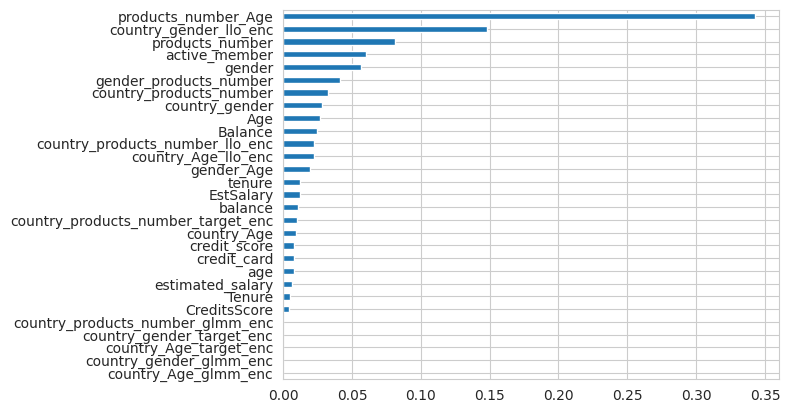

In [91]:
# loo,target
feat_importances = pd.Series(XGB_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

In [92]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

test Accuracy: 0.958245466048081
test Recall: 0.9532710280373832
test F1 score: 0.9640130861504906


In [93]:
# Banlance, Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

test Accuracy: 0.958245466048081
test Recall: 0.9532710280373832
test F1 score: 0.9640130861504906


In [94]:
# Banlance, Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

test Accuracy: 0.958245466048081
test Recall: 0.9532710280373832
test F1 score: 0.9640130861504906


Cross-Validtion
---

In [95]:
from sklearn.model_selection import cross_val_score, StratifiedKFold


In [96]:
# Define the model
XGB_model = XGBClassifier()

# Define the cross-validation strategy, for example, Stratified K-Folds
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(XGB_model, X_train, y_train, cv=cv_strategy, scoring='accuracy')


In [97]:
# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# If you want to fit the model on the entire training data after cross-validation
XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)

Cross-validation scores: [0.95938819 0.95042194 0.93881857 0.95622363 0.9556962 ]
Mean cross-validation score: 0.9521097046413501


Model Evaluation and Visulization
---
use xgboost model as a template hew

<Figure size 2000x2000 with 0 Axes>

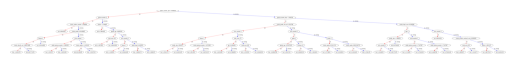

In [98]:
from xgboost import plot_tree

# Plot the first tree
plt.figure(figsize=(20, 20))
plot_tree(XGB_model, num_trees=0)
plt.show()

In [99]:
!pip install -q shap

In [ ]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(XGB_model, X_train)
shap_values = explainer(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)

# Dependence plot for a specific feature
shap.dependence_plot("feature_name", shap_values, X_train)

# Force plot for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0])

 19%|====                | 1830/9480 [00:20<01:23]       

In [ ]:
# $learning curve

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(XGB_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [ ]:
# ROC
from sklearn.metrics import roc_curve, auc

y_pred_proba = XGB_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Coffusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = XGB_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# Create a neural network model
k_model = Sequential()
k_model.add(Dense(11, activation='relu', input_shape=(df.shape[1],)))
k_model.add(Dense(4, activation='relu'))
k_model.add(Dense(1, activation='sigmoid'))
k_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Create a Keras model
k_model = Sequential()
k_model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
k_model.add(Dense(32, activation='relu'))
k_model.add(Dense(1, activation='sigmoid'))
k_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training data
k_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

In [ ]:
# Predict on the testing data
y_pred = k_model.predict(X_test)

# Convert the predictions to binary labels
y_pred = (y_pred > 0.4).astype(int)


In [ ]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

In [ ]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

Metrics
---

1. `Precision`: Precision is the ratio of true positives (TP) to the sum of true positives and false positives (FP):
Precision = TP / (TP + FP)

2. `Recall`: Recall is the ratio of true positives (TP) to the sum of true positives and false negatives (FN):
Recall = TP / (TP + FN)

3. `F1`-score: The F1-score is the harmonic mean of precision and recall:
$$F1 = 2  \frac{\text{Precision}\times \text{Recall}}{\text{Precision + Recall}}$$

In [ ]:
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
accuracy_score(y_test, y_pred)

In [ ]:
# loo, GLMM, target, country_products_number
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
accuracy_score(y_test, y_pred)

In [ ]:
# loo,  country_products_number
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
accuracy_score(y_test, y_pred)

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.summer):
    plt.clf
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=22)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(cnf_matrix, np.unique(y_pred))


In [ ]:
plot_confusion_matrix(cnf_matrix, np.unique(y_pred))

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 20)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = XGB_model, X = X_train, y = y_train, cv = 20)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = XGB_model, X = X_test, y = y_test, cv = 20)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Random Forest Classification, rfc
---
Set of week models

In [ ]:
rfc1= RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=1) # Pass hyperparameters

rfc1.fit(X_train, y_train)

In [ ]:
def plot_feature_importances(model):
    feat_importances = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
    feat_importances.plot(kind = 'barh');
    #plt.barh(range(n_features), model.feature_importances_, align='center')
    #plt.yticks(np.arange(n_features), X.columns)

In [ ]:
plot_feature_importances(rfc1)

In [ ]:
#Calculate the accuracy
y_pred = rfc1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

In [ ]:
def score_model(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    #model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('test Accuracy:', accuracy)

    recall = recall_score(y_test, y_pred)
    print('test Recall:', recall)

    f1 = f1_score(y_test, y_pred)
    print('test F1 score:', f1)

#score_model(rfc1)

In [ ]:
score_model(XGB_model)

In [ ]:
rfc2= RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=42) # Pass hyperparameters
rfc2.fit(X_train, y_train)

In [ ]:
score_model(rfc2)

In [ ]:
# Get feature importance
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
# Tree Viz
from sklearn.tree import plot_tree

# Plot the first tree in the forest
plt.figure(figsize=(20, 20))
plot_tree(rfc.estimators_[0], feature_names=X_train.columns, filled=True)
plt.show()

In [ ]:
# Initialize the SHAP explainer
explainer = shap.Explainer(rfc, X_train)
shap_values = explainer(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)

# Dependence plot for a specific feature
shap.dependence_plot("feature_name", shap_values, X_train)

# Force plot for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0])

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(rfc, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rfc, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the mean and standard deviation for training and validation scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = rfc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
lgbm_model = LGBMClassifier(learning_rate = 0.07,
                        max_delta_step = 2,
                        n_estimators = 100,
                        max_depth = 10,
                        eval_metric = "logloss",
                        objective='binary',
                        random_state=42)
lgbm_model.fit(X_train, y_train)

In [ ]:
score_model(lgbm_model)

In [ ]:
from xgboost import XGBClassifier

XGB_model2 = XGBClassifier(
    learning_rate=0.07,
    max_delta_step=2,
    n_estimators=100,
    max_depth=10,
    eval_metric="logloss",
    objective="binary:logistic",
    random_state=42,
    n_jobs=-1,
    booster="gbtree",
    nthread=4,
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    missing=0,
    num_parallel_tree=1,
    predictor="auto",
    max_leaves=31,
    tree_method="hist",
    gpu_id=-1,
    enable_categorical=False,
    validate_parameters=True,
    disable_default_eval_metric=False,
    grow_policy="depthwise",
    max_bin=255,
    min_data_in_leaf=1,
    min_child_samples=20,
    max_depth_reduction=0,
    min_data_in_bin=1,
    min_gain_to_split=0,
    min_split_gain=0,
    min_split_loss=0,
    )

XGB_model2.fit(X_train, y_train)

In [ ]:
score_model(XGB_model2)

In [ ]:
score_model(XGB_model2)

In [ ]:
score_model(XGB_model2)

In [ ]:
ce.

In [ ]:
cat_model=CatBoostClassifier(learning_rate=0.03,silent=True)
cat_model.fit(X_train, y_train)

In [ ]:
score_model(cat_model)

In [ ]:
cfm = confusion_matrix(y_test, y_pred=cat_model.predict(X_test))
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='CatBoost Prediction')
tn, fp, fn, tp = cfm.ravel()

In [ ]:

plot_confusion_matrix(cfm, ['Non Churn','Churn'],title='Catboost')


Ensemble of Models
---

In [ ]:
list_of_models = {
    'logistic_regression' : LogisticRegression(random_state = 42, max_iter = 10000),
    'Random_forest' : RandomForestClassifier(n_estimators = 150, max_depth = 4, random_state = 42),
    "XGBoost" : xgb.XGBClassifier(n_estimators = 200, max_depth = 5, random_state = 42)
}

In [ ]:
f1_train_scores = []
f1_test_scores = []
recall_test_scores = []
model_names = list(list_of_models.keys())

In [ ]:
model_names

In [ ]:
for model in model_names:
    print("\nFor Model:", model)

    list_of_models[model].fit(X_train, y_train)

    print("\nFor Training Set:")

    y_train_pred = list_of_models[model].predict(X_train)

    f1_train = f1_score(y_train, y_train_pred, average='macro')
    print("\nMacro F1 Score:", f1_train)

    print("\nConfusion Matrix:")
    Confusion_Matrix = confusion_matrix(y_train.values, y_train_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = Confusion_Matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

    print("For Test Set:")

    y_test_pred = list_of_models[model].predict(X_test)

    f1_test = f1_score(y_test, y_test_pred, average='macro')
    print("\nMacro F1 Score:", f1_test)

    recall_test_score = recall_score(y_test, y_test_pred, average='macro')

    print("\nConfusion Matrix:")
    Confusion_Matrix = confusion_matrix(y_test, y_test_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = Confusion_Matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)
    recall_test_scores.append(recall_test_score)

In [ ]:
print("model_names           f1_train_scores  f1_test_scores   recall_test_scores")
for i in range(len(model_names)):
    print(f"{model_names[i]:<22} {f1_train_scores[i]:.6f}          {f1_test_scores[i]:.6f}.          {recall_test_scores[i]:.6f}")

In [ ]:
df_score=pd.DataFrame()
df_score['model']=model_names
df_score['f1_train_scores']=f1_train_scores
df_score['f1_test_scores']=f1_test_scores
df_score['recall_test_scores']=recall_test_scores
df_score

In [ ]:
# convert to table
from IPython.display import HTML
HTML(df_score.to_html())

In [ ]:
log_reg_model = LogisticRegression(random_state = 42, max_iter = 10000)
xgb_model = xgb.XGBClassifier(n_estimators = 200, max_depth = 5, random_state = 42)

#fit logistic regression model
log_reg_model.fit(X, y)
#fit xgb model
xgb_model.fit(X, y)

#predict using ensemble of both the models
y_pred_proba_log = [x[1] for x in log_reg_model.predict_proba(X)]
y_pred_proba_xgb = [x[1] for x in xgb_model.predict_proba(X)]
y_pred_proba_log = np.array(y_pred_proba_log)
y_pred_proba_xgb = np.array(y_pred_proba_xgb)

y_pred_proba = (y_pred_proba_log + y_pred_proba_xgb) / 2.0

y_pred = np.where(y_pred_proba > 0.4, 1, 0)




In [ ]:
f1 = f1_score(y, y_pred, average = 'macro')
print("\nMacro F1 Score:", f1)

recall = recall_score(y, y_pred, average = 'macro')
print("\nMacro Recall Score:", recall)

print("\nConfusion Matrix:")
Confusion_Matrix = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = Confusion_Matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
#Save and export models to be used in deployment
import pickle
#Save and export models to be used in deployment

pickle.dump(log_reg_model, open('churn_logistic_regression_model_for_deployment.pkl','wb'))
pickle.dump(xgb_model, open('churn_xgb_model_for_deployment.pkl','wb'))

In [ ]:
X.head(5)

In [ ]:
X.columns

Imbalance Problem
---
Gerenally, churn data is a little small such that affects the prediction. Here we can enlarge the churn dataset by simulation, and re-make the prediction model:

```python
X = df_data_model.loc[:, df_data_model.columns!=’churn’]
y = df_data_model[‘churn’]

# from imblearn.over_sampling import SMOTE
smote = SMOTE()
# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X,y)
print(‘Original dataset shape’, Counter(y))
print(‘Resample dataset shape’, Counter(y_smote))

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_smote, y_smote, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print(‘Train’, X_train.shape, y_train.shape)
print(‘Test’, X_valid.shape, y_valid.shape)

#adaboost model training
ada_clf = AdaBoostClassifier(random_state=0)
kfold = KFold(n_splits = 10, random_state = 5)
results = cross_val_score(ada_clf, X_train, y_train, cv = kfold)
print(results.mean())


#train model
ada_clf.fit(X_train, y_train)
#make predictions
y_pred = ada_clf.predict(X_valid)
#metrics
print('Model accuracy score: ',accuracy_score(y_valid,y_pred))
print('Confusion matrix: ')
print(confusion_matrix(y_valid,y_pred))
print(classification_report(y_valid,y_pred))
```

Appendix, Pycaret Review
---

In [ ]:
!pip install -U pycaret

In [ ]:
from pycaret.classification import *

In [ ]:
X['churn']=y

In [ ]:
X.head(2)

In [ ]:
clf = setup(data=X,target='churn',session_id=123)
best = compare_models()

In [ ]:
X.head(2)

Improvements
---
- Using SHAP to analyze the key factors driving churn predictions from the XGBoost model
- Identifying high-risk customers based on a probability threshold
- Implementing a function to regularly score the full customer base and save high-risk cases
- Setting up the scoring function to run as a recurring monthly job

In [ ]:
!pip install -q shap

In [ ]:
# Root Cause Analysis
import shap
import matplotlib.pyplot as plt

In [ ]:


# Load trained XGBoost model
xgb_model = pickle.load(open('churn_xgb_model.pkl', 'rb'))

# Sample customer data
customer_data = X.sample(100)

# Compute SHAP values to understand feature importance
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(customer_data)

# Visualize top factors driving churn predictions
shap.summary_plot(shap_values, customer_data, plot_type="bar")
plt.show()

# Churn Prevention
# Identify high-risk customers based on churn probability threshold
from sklearn.metrics import roc_curve

# Compute probability predictions
y_prob = xgb_model.predict_proba(X)[:,1]

# Compute false positive and true positive rates
fpr, tpr, thresholds = roc_curve(y, y_prob)

# Find threshold for 80% tpr
tpr80 = 0.8
idx = np.argwhere(tpr >= tpr80)[0]
threshold = thresholds[idx]

# Customers above threshold are high-risk
high_risk_customers = X[y_prob >= threshold]

print(f"Number of high-risk customers: {len(high_risk_customers)}")

# Monitoring System
import datetime

# Score full customer base each month
def score_customer_base(date):
    customers = get_all_customers(date)
    customers = preprocess_data(customers)
    scores = xgb_model.predict_proba(customers)[:,1]
    high_risk = customers[scores >= threshold]

    # Save high-risk cases for further action
    high_risk.to_csv(f"high_risk_{date}.csv")

# Set up monitoring job to run monthly
next_run = datetime.datetime.today() + datetime.timedelta(days=30)
score_customer_base(next_run)

Homework
---
Whatever method was used, `Domain Expertise` is the the important factor where the decision was made.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# gdrive/MyDrive/2023/2023-2-Python-AI

In [ ]:
!ls gdrive/MyDrive/2023/2023-2-Python-AI/data

In [ ]:
# Very complainted in the second issue
import pandas as pd
df = pd.read_csv('gdrive/MyDrive/2023/2023-2-Python-AI/data/Consumer_Complaints.csv.zip')
df.head(2)

In [ ]:
df.info()

In [ ]:
# delete the feature which is absent too many items
df = df[pd.notnull(df['Consumer complaint narrative'])]
len(df)

In [ ]:
df = df[['Product', 'Consumer complaint narrative']]
df['category_id'] = df['Product'].factorize()[0]
df.head(5)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df['Consumer complaint narrative']).toarray()
labels = df.category_id
features.shape

In [ ]:
import gc
gc.collect()

In [ ]:
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [ ]:
# failed, scikit-learn 1.2.2
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

In [ ]:
import numpy as np
from scipy.stats import beta

class BetaTargetEncoder:
    def __init__(self):
        self.encoder = {}

    def fit(self, X, y):
        for i, category in enumerate(np.unique(X)):
            category_values = X[X == category]
            target_values = y[X == category]
            self.encoder[category] = beta.fit(target_values, [len(target_values), len(target_values) - len(target_values)])

    def transform(self, X):
        encoded_values = []
        for category in np.unique(X):
            category_values = X[X == category]
            encoded_values.append(self.encoder[category].sf(category_values))
        return np.array(encoded_values).T

# Example usage:
import numpy as np
from scipy.stats import beta

class BetaTargetEncoder:
    def __init__(self):
        self.encoder = {}

    def fit(self, X, y):
        for i, category in enumerate(np.unique(X)):
            category_values = X[X == category]
            target_values = y[X == category]
            self.encoder[category] = beta.fit(target_values, [len(target_values), len(target_values) - len(target_values)])

    def transform(self, X):
        encoded_values = []
        for category in np.unique(X):
            category_values = X[X == category]
            encoded_values.append(self.encoder[category].sf(category_values))
        return np.array(encoded_values).T

# Example usage:
X2 = np.array(['A', 'A', 'B', 'B', 'B', 'C', 'C', 'C'])
y2 = np.array([1, 2, 3, 4, 5, 6, 7, 8])

bte = BetaTargetEncoder()
bte.fit(X2, y2)
encoded = bte.transform(X2)
print(encoded)




Appendix
---
1. Hyperparmeter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


In [ ]:
xgb3 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [ ]:
folds = 3
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
random_search = RandomizedSearchCV(xgb, param_distributions=params, \
                                   n_iter=param_comb, scoring='accuracy',\
                                   n_jobs=4,
                                   cv=skf.split(X_train,y_train),
                                   verbose=3, random_state=42 )

In [ ]:
random_search.fit(X_train,y_train)


In [ ]:
print(random_search.best_score_)


In [ ]:
from pprint import pprint
pprint(random_search.best_estimator_.get_params())

In [ ]:
# Volting

from sklearn.ensemble import VotingClassifier

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('rfc', rfc),
    ('catboost', catboost),
    ('lgbm', lgbm)], voting='hard')

# Fit the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)

In [ ]:
# Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rfc', rfc),
        ('catboost', catboost),
        ('lgbm', lgbm)],
    final_estimator=LogisticRegression()
)

# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

In [ ]:
# Blending

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the training data into two parts
X_train_part1, X_train_part2, y_train_part1, y_train_part2 = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Initialize the models
xgb = XGBClassifier()
rfc = RandomForestClassifier()
catboost = CatBoostClassifier(verbose=0)
lgbm = LGBMClassifier()

# Fit the models on the first part of the training data
xgb.fit(X_train_part1, y_train_part1)
rfc.fit(X_train_part1, y_train_part1)
catboost.fit(X_train_part1, y_train_part1)
lgbm.fit(X_train_part1, y_train_part1)

# Generate predictions on the second part of the training data
preds_part2_xgb = xgb.predict_proba(X_train_part2)[:, 1]
preds_part2_rfc = rfc.predict_proba(X_train_part2)[:, 1]
preds_part2_catboost = catboost.predict_proba(X_train_part2)[:, 1]
preds_part2_lgbm = lgbm.predict_proba(X_train_part2)[:, 1]

# Create a new dataset using these predictions as features
X_train_meta = np.column_stack((preds_part2_xgb, preds_part2_rfc, preds_part2_catboost, preds_part2_lgbm))

# Train the meta-model
meta_model = LogisticRegression()
meta_model.fit(X_train_meta, y_train_part2)

# Generate predictions for the test set using the base models
preds_test_xgb = xgb.predict_proba(X_test)[:, 1]
preds_test_rfc = rfc.predict_proba(X_test)[:, 1]
preds_test_catboost = catboost.predict_proba(X_test)[:, 1]
preds_test_lgbm = lgbm.predict_proba(X_test)[:, 1]

# Create a new dataset for the test set using these predictions as features
X_test_meta = np.column_stack((preds_test_xgb, preds_test_rfc, preds_test_catboost, preds_test_lgbm))

# Make final predictions using the meta-model
y_pred = meta_model.predict(X_test_meta)


In [ ]:
#
from sklearn.ensemble import VotingClassifier

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('rfc', rfc),
    ('catboost', catboost),
    ('lgbm', lgbm)], voting='soft')  # Use 'hard' for hard voting

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
#

from mlxtend.classifier import StackingClassifier


# Initialize the meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(classifiers=[xgb, rfc, catboost, lgbm], meta_classifier=meta_model)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

In [ ]:
#
from pycaret.classification import *

# Initialize the PyCaret setup
clf1 = setup(data, target='churn')

# Compare models and select top models for stacking
top3 = compare_models(n_select=3)

# Create a stack of models
stacker = stack_models(estimator_list=top3, meta_model=LogisticRegression())

# Finalize the model
final_stacker = finalize_model(stacker)

# Predict on new data
predictions = predict_model(final_stacker, data=test_data)


In [ ]:
#
from vecstack import StackingTransformer

# Initialize the base models
models = [
    ('xgb', XGBClassifier()),
    ('rfc', RandomForestClassifier()),
    ('catboost', CatBoostClassifier(verbose=0)),
    ('lgbm', LGBMClassifier())
]

# Initialize the stacking transformer
stack = StackingTransformer(estimators=models, regression=False, verbose=2, random_state=42)

# Fit the stacking transformer
stack.fit(X_train, y_train)

# Transform the training set
X_train_transformed = stack.transform(X_train)

# Initialize and fit the meta-model
meta_model = LogisticRegression()
meta_model.fit(X_train_transformed, y_train)

# Transform the test set
X_test_transformed = stack.transform(X_test)

# Make predictions
y_pred = meta_model.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Implement
---
Implement the model result on the cloud is the final step of procedures. Thought we do not introduce details here, only outline was described:
1. prepare the model output, model.pkl for instance, and create the Python code with streamlit package for inputing the data:
   - use